<a href="https://colab.research.google.com/github/soesantanu/soesantanu.github.io/blob/main/LASSO_comparison_(m%2Cn)%3D(1000%2C2000).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import division
import numpy as np
import numpy.linalg as LA
from time import time
from itertools import count
from numpy.linalg import norm as LA_norm
import matplotlib.pyplot as plt
import builtins
import seaborn as sns

# This section is from the paper titled "A golden ratio primal-dual algorithm for structured convex optimization" by Xiaokai Chang et al.
# Define proximal operators
def prox_norm_1(x, eps, u=0):
    """
    Find proximal operator of function eps*||x-u||_1
    """
    x1 = x + np.clip(u - x, -eps, eps)
    return x1

def f_conj(y):
    return 0.5*(y+b).dot(y+b)

def g(x):
    return la*LA.norm(x,1)

def prox_g(x, rho):
    return prox_norm_1(x,la*rho)

def prox_f_conj(y, rho):
    return (y - rho*b)/(1+rho)

def prox_f(y, rho):
    return (y + rho*b)/(1+rho)

# define energy
def J(x,y, min_val):
    t = A.dot(x)-b
    return np.abs(0.5* t.dot(t) + la* LA.norm(x,1) - min_val)

In [ ]:
#######################################################################################################################################
# Define the algorithms
def VI_adaptive_Golden(J, prox_g, prox_f_conj, K, x0, y0, tau, theta, rho,min_val, tau_max, phi,numb_iter=100):
    begin = time()
    x, y = x0, y0
    x1, y1 = x0, y0
    z_x, z_y = x0, y0
    values = [J(x0, y0, min_val)]
    func_value = [J(x0,y0,0)]
    iters = []
    stop_iter = numb_iter
    L_n = None
    tau_prev = tau
    theta_prev = theta
    tt = [0]

    for i in range(numb_iter):
        z0 = np.concatenate((x, y))
        z1 = np.concatenate((x1, y1))
        Fz_0 = np.concatenate((K.T.dot(y), -K.dot(x)))
        Fz_1 = np.concatenate((K.T.dot(y1), -K.dot(x1)))
        z_norm = LA.norm(z0 - z1)
        Fz_norm = LA.norm(Fz_0 - Fz_1)
        if Fz_norm != 0:
            L_n = (phi * theta_prev / (4 * tau_prev)) * ((z_norm / Fz_norm) ** 2)
            tau_n = builtins.min(rho * tau_prev, L_n, tau_max)
        else:
            tau_n = builtins.min(rho * tau_prev, tau_max)
        z_x = x1 - (1 / phi) * (x1 - z_x)
        z_y = y1 - (1 / phi) * (y1 - z_y)

        x2 = prox_g(z_x - tau_n * K.T.dot(y1), tau_n)
        y2 = prox_f_conj(z_y + tau_n * K.dot(x1), tau_n)
        theta_n = phi * (tau_n / tau_prev)
        tau_prev = tau_n
        theta_prev = theta_n
        values.append(J(x2, y2, min_val))
        func_value.append(J(x2,y2,0))
        print(f"Iteration {i}: J_gap = {J(x2, y2, min_val)}, tau_n = {tau_n}, z_norm = {z_norm}, F_z_norm = {Fz_norm}, L_n = {L_n}")
        x, y = x1, y1
        x1, y1 = x2, y2

        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-9:
            stop_iter = i+1
            print ("Iter:", i+1)
            print(f"Converged in {stop_iter} iters, {tt[-1]:.3f}s")
            # print ("----- Adaptive Golden-Ratio Algorithm for VI -----")
            print ("Time execution:", round(end - begin,2))
            break

    if err > 1e-9:
     print ("Adaptive Golden-Ratio Algorithm for VI does not terminate after", round(end - begin,2), "seconds")
    return [values,func_value, x, y,iters, stop_iter, tt]



def pd_adaptive_Golden(J, prox_g, prox_f_conj, K, x0, y0, tau, theta, beta, tau_max, min_val, rho_val, phi, numb_iter=100):
    begin = time()

    x, y, z = x0, y0, x0
    values = [J(x0, y0, min_val)]
    func_value = [J(x0,y0,0)]
    tau_prev = tau
    theta_prev = theta
    tt = [0]
    tau_values = []
    sigma_values = []

    for i in range(numb_iter):
        z = x - (1 / phi) * (x - z)
        x1 = prox_g(z - tau_prev * K.T.dot(y), tau_prev)
        Kx1 = K.dot(x1)
        Kx = K.dot(x)

        Kx_norm = LA.norm(Kx - Kx1)
        x_norm = LA.norm(x - x1)
        if Kx_norm != 0:
            L_n = (theta_prev / (4 * beta * tau_prev)) * (x_norm / Kx_norm) ** 2
            tau_n = builtins.min(rho_val * tau_prev, L_n, tau_max)
        else:
            tau_n = builtins.min(rho_val * tau_prev, tau_max)

        sigma_n = beta * tau_n
        y1 = prox_f_conj(y + sigma_n * Kx1, sigma_n)
        print(f"Iteration {i}: J_gap = {J(x1, y1, min_val)}, tau_n = {tau_n}, x_norm = {x_norm}, Kx_norm = {Kx_norm}, L_n = {L_n}")
        theta_n = phi * (tau_n / tau_prev)
        tau_prev = tau_n
        theta_prev = theta_n
        values.append(J(x1, y1, min_val))
        func_value.append(J(x1,y1,0))
        x, y = x1, y1
        tau_values.append(tau_n)  # Store tau_n value
        sigma_values.append(sigma_n)  # Store sigma_n value
        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-9:
            print ("Iter:", i+1)
            print ("----- Adaptive Golden-Ratio PDA -----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-9:
      print ("Adaptive Golden-Ratio PDA does not terminate after", round(end - begin,2), "seconds")
    return [values, func_value, x, y, tt, sigma_values, tau_values]



def pd_Golden_Partial_adaptive(J, prox_g, prox_f_conj, K, x0, y0, mu, beta, phi, min_val,tau, numb_iter=100):
    begin = time()
    x, y, z = x0, y0, x0
    values = [J(x0, y0, min_val)]
    func_value = [J(x0,y0,0)]
    tt = [0]
    tau_prev = tau

    for i in range(numb_iter):

        z = x - (1 / phi) * (x - z)
        x1 = prox_g(z - tau_prev * K.T.dot(y), tau_prev)
        x_norm = LA.norm(x - x1)
        Kx_norm = LA.norm(K.dot(x) - K.dot(x1))

        if Kx_norm != 0:
            L_n =  (mu * x_norm )/(np.sqrt(beta) * Kx_norm)
            tau_n = builtins.min(tau_prev, L_n)
        else:
            tau_n = tau_prev

        sigma_n = beta * tau_n
        y1 = prox_f_conj(y + sigma_n * K.dot(x1), sigma_n)
        print(f"Iteration {i}:J_gap = {J(x1, y1, min_val)}, tau_n = {tau_n}, x_norm = {x_norm}, Kx_norm = {Kx_norm}, L_n = {L_n}")
        tau_prev = tau_n
        values.append(J(x1, y1, min_val))
        func_value.append(J(x1,y1,0))
        x, y = x1, y1

        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-9:
            print ("Iter:", i+1)
            print ("----- Golden-Ratio PDA with partial adaptive step size-----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-9:
      print ("Golden-Ratio PDA with partial adaptive step size does not terminate after", round(end - begin,2), "seconds")

    return [values,func_value, x, y,tt]



def pd(J, prox_g, prox_f_conj, K,  x0, y0, sigma, tau, min_val, numb_iter=100):
    """
    Primal-dual algorithm of Pock and Chambolle for the problem min_x
    max_y [<Kx,y> + g(x) - f*(y)]
    J denotes some function which we compute in every iteration to
    study perfomance. It may be energy, primal-dual gap, etc.
    """
    begin = time()
    theta = 1.0
    x, y, z = x0, y0, x0
    values = [J(x0, y0, min_val)]
    func_value = [J(x0,y0,0)]
    tt = [0]

    for i in range(numb_iter):
        x1 = prox_g(x - tau * K.T.dot(y), tau)
        z = x1 + theta * (x1 - x)
        y = prox_f_conj(y + sigma * K.dot(z), sigma)
        values.append(J(x, y, min_val))
        func_value.append(J(x,y,0))
        print(f"Iteration {i}: J_gap = {J(x, y, min_val)}, tau = {tau}, theta = {theta}")
        x = x1

        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-9:
            print ("Iter:", i+1)
            print ("----- Primal-dual method -----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-9:
      print ("Primal-dual method does not terminate after", round(end - begin,2), "seconds")

    return [values, func_value, x, y,tt]



def pd_Golden(J, prox_g, prox_f_conj, K,  x0, y0, sigma, tau, phi, min_val, numb_iter=100):
    """
    Golden-Ratio Primal-dual algorithm for the problem min_x
    max_y [<Kx,y> + g(x) - f*(y)]
    J denotes some function which we compute in every iteration to
    study perfomance. It may be energy, primal-dual gap, etc.
    """
    begin = time()

    x, y, z = x0, y0, x0
    values = [J(x0, y0, min_val)]
    func_value = [J(x0,y0,0)]
    tt = [0]

    for i in range(numb_iter):
        z = x-(1/phi)*(x - z)
        x = prox_g(z - tau * K.T.dot(y), tau)

        y = prox_f_conj(y + sigma * K.dot(x), sigma)

        values.append(J(x, y, min_val))
        func_value.append(J(x,y,0))
        print(f"Iteration {i}: J_gap = {J(x, y, min_val)}, tau = {tau}, phi = {phi}")
        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-9:
            print ("Iter:", i+1)
            print ("----- Golden-Ratio Primal-dual method -----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-9:
      print ("Golden-Ratio Primal-dual method does not terminate after", round(end - begin,2), "seconds")
    return [values, func_value, x, y,tt]


def pd_Golden_linesearch(J, prox_g, prox_f_conj, K,  x0, y1, tau, beta, min_val, numb_iter=100, tol = 1e-8):
    """
    Golden-Ratio PDA with linesearch for problem min_x max_y [
    <Kx,y> + g(x) - f*(y)].
    beta denotes sigma/tau from a classical primal-dual algorithm.
    """
    begin = time()
    values = [J(x0, y1, min_val)]
    func_value = [J(x0,y1,0)]
    tt = [0]

    phi = 1.5
    rho = 1/phi+1/phi**2
    mu = 0.7
    delta = 0.99
    iterates = [values, func_value, x0, x0, y1, tau] + [tt, 0]
    sqrt_b = np.sqrt(beta)

    # function T is an operator that makes one iteration of the algorithm:
    # (x1, y1) = T(x,y, history)

    def T(values, func_value, z, x_old, y, tau_old, tt,l):
        z = ((phi-1)*x_old + z)/phi
        x = prox_g(z - tau_old * K.T.dot(y), tau_old)
        Kx = K.dot(x)
        tau = tau_old * rho
        for j in count(0):
            th = tau/tau_old
            y1 = prox_f_conj(y + tau * beta * Kx, tau * beta)
            if sqrt_b * tau * LA.norm(K.T.dot(y1 - y)) <= delta*np.sqrt(phi*th) * LA.norm(y1 - y):
                break
            else:
                tau *= mu
                l +=1

        #print(phi)

        values.append(J(x, y1, min_val))
        func_value.append(J(x,y1,0))
        #steps.append(l)
        tt.append(time() - begin)
        res = [values, func_value, z, x, y1, tau, tt,l]
        return res

    for i in range(numb_iter):
        iterates = T(*iterates)
        err = iterates[0][-1]
        x = iterates[3]
        y1 = iterates[4]
        tau = iterates[5]
        print(f"Iteration {i}:J_gap = {J(x, y1, min_val)}, tau = {tau}, phi = {phi}")
        end = time()
        if err <= tol:
            print ("Iter:", i+1)

            print ("----- Golden-Ratio Primal-dual method with linesearch-----")
            print ("Time execution:", round(end - begin,2))
            break

    if err > tol:
        print ("Golden-Ratio Primal-dual method with linesearch does not terminate after", round(end - begin,2), "seconds")
    print ("Number of linesearch:", iterates[-1])
    return [iterates[i] for i in [0, 1, -2,-1]]


In [ ]:
#########################################################################################
n = 2000
m = 1000
# s = 100
# la = 0.1
# gen = 100
# np.random.seed(gen)
# A = np.random.normal(0,1,(m,n))

# np.random.seed(gen)
# w = np.random.uniform(-10,10, n)
# w[s:] = 0
# np.random.seed(gen)
# w = np.random.permutation(w)

# np.random.seed(gen)
# nu = np.random.normal(0,0.1, m)
# b = A.dot(w) + nu
##############################################################################################
s = 100
la = 0.1
gen = 100

np.random.seed(gen)
B = np.random.normal(0,1, (m,n))
p = 0.5
A = np.zeros((m,n))
A[:,0] = B[:,0]/np.sqrt(1-p**2)
for j in np.arange(1,n):
    A[:,j] = p*A[:,j-1] + B[:,j]

np.random.seed(gen)
w = np.random.uniform(-10,10, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)
np.random.seed(gen)
nu = np.random.normal(0, 0.1, m)
b = A.dot(w) + nu

# Starting points
x0 = np.zeros(n)
y0 = - b

L = np.sqrt(np.max(LA.eigh(A.dot(A.T))[0]))
beta = .2
beta1 = 1 #.5
phi_1 = 1.618
phi2 = 1.76
beta2 = .01
phi = 1.6
s_p = np.sqrt(phi)
rho_val = 1./ phi + 1./ phi **2
theta = 2
tau_2 = 1
mu = 0.77236
tau_max = 100000000
tau = 1.0 /  L
sigma = 1.0 / L


In [ ]:
N = 20000
c_= 0

ans29 = pd_Golden_linesearch(J, prox_g, prox_f_conj, A,  x0, y0, tau_2, beta,c_, numb_iter=N, tol = 1e-9)
ans1 = VI_adaptive_Golden(J, prox_g, prox_f_conj,  A, x0, y0, tau_2, theta, rho_val,c_,tau_max, phi, numb_iter=N)
ans17 = pd(J, prox_g, prox_f_conj, A,  x0, y0, .04*sigma, 25*tau,c_, numb_iter=N)

ans3 =  pd_Golden(J, prox_g, prox_f_conj, A,  x0, y0,  s_p*sigma , s_p*tau , phi_1,c_, numb_iter=N)
ans4 = pd_Golden_Partial_adaptive(J, prox_g, prox_f_conj, A, x0, y0, mu, beta, phi2,c_, tau_2, numb_iter=N)
# mu = .30
# ans23 = pd_Golden_Partial_adaptive(J, prox_g, prox_f, dist_sub, A, x0, y0, mu, beta, phi, la, b, tau_2, numb_iter=N)
# mu = .15
# ans24 = pd_Golden_Partial_adaptive(J, prox_g, prox_f, dist_sub, A, x0, y0, mu, beta, phi, la, b, tau_2, numb_iter=N)
# phi = 2
# rho1 = 1.49
# ans19 = pd_Golden_relaxed(J, prox_g, prox_f_conj, A,  x0, y0, .05*sigma, 20*tau, phi, rho1, numb_iter=N)

# min_val = builtins.min(ans29[0]+ans2[0]+ans1[0])
# print(min_val)

Streaming output truncated to the last 5000 lines.
Iteration 15001:J_gap = 51.04165411722511, tau_n = 0.01922503945344937, x_norm = 4.054841341822244e-14, Kx_norm = 1.201874754320443e-12, L_n = 0.05826656677148013
Iteration 15002:J_gap = 51.0416541172251, tau_n = 0.01922503945344937, x_norm = 4.035636009543349e-14, Kx_norm = 1.2294641655723373e-12, L_n = 0.05668927325190761
Iteration 15003:J_gap = 51.0416541172251, tau_n = 0.01922503945344937, x_norm = 4.013320549583842e-14, Kx_norm = 1.2207985723703787e-12, L_n = 0.056775976457409255
Iteration 15004:J_gap = 51.04165411722511, tau_n = 0.01922503945344937, x_norm = 3.992355267272414e-14, Kx_norm = 1.2198761188243887e-12, L_n = 0.05652209199323467
Iteration 15005:J_gap = 51.0416541172251, tau_n = 0.01922503945344937, x_norm = 3.999254962710272e-14, Kx_norm = 1.2422784263730947e-12, L_n = 0.055598736881561
Iteration 15006:J_gap = 51.0416541172251, tau_n = 0.01922503945344937, x_norm = 4.0024050821190425e-14, Kx_norm = 1.2615873362277748e-

In [ ]:
min_values = []  # Create a list to store minimum values from each list
for v in [ans29[0], ans3[0], ans4[0], ans17[0]]:
    # Get the minimum value of the list 'v' and append it to min_values
    min_values.append(builtins.min(v))

# Now, find the overall minimum from the collected minimum values
min_val = min(min_values)

print(f'{min_val:.30f}')  # Print with 30 decimal places

51.041654117225078834962914697826


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

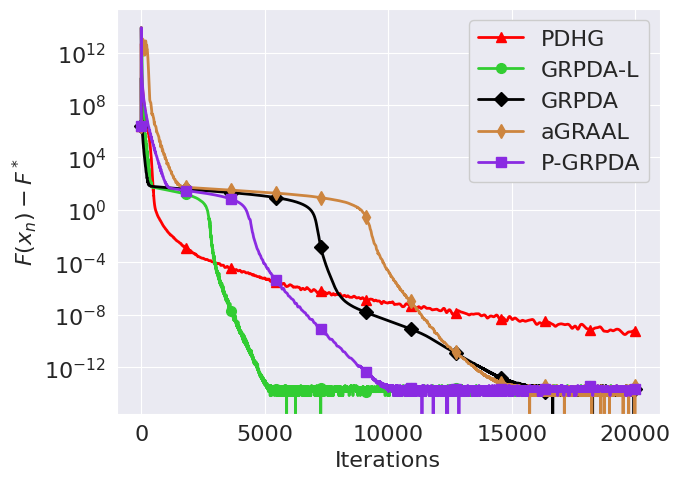

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ——— 1) Set seaborn style ———
sns.set_style('darkgrid')
plt.rcParams['legend.facecolor'] = plt.rcParams['axes.facecolor']

# ——— 2) Update Matplotlib parameters ———
plt.rcParams.update({
    'font.size':        13,
    'figure.figsize':   (7, 5),
    'legend.fontsize':  16,
    'lines.linewidth':  2,
    'axes.labelsize':   16,
    'xtick.labelsize':  16,
    'ytick.labelsize':  16,
    'xtick.major.pad':  4,
    'ytick.major.pad':  4,
})

# —3) Compute the common minimum for vertical shift ———
min_val = min(np.min(ans[0]) for ans in [ans1, ans3, ans4, ans17, ans29])

# — 4) Define your plots: (iters, error, label, marker, color) ———
plots = [
    (np.arange(len(ans17[0])), np.array(ans17[0]) - min_val, 'PDHG',    '^', 'red'),
    (np.arange(len(ans29[0])), np.array(ans29[0]) - min_val, 'GRPDA‑L', 'o', 'limegreen'),
    (np.arange(len(ans3[0])),  np.array(ans3[0])  - min_val, 'GRPDA',   'D', 'black'),
    (np.arange(len(ans1[0])),  np.array(ans1[0])  - min_val, 'aGRAAL',  'd', '#CD853F'),
    (np.arange(len(ans4[0])),  np.array(ans4[0])  - min_val, 'P‑GRPDA', 's', '#8A2BE2'),
]

# —5) Plot each with markers every ~10% of iterations ———
for x, y, lbl, mk, col in plots:
    me = max(1, len(x)//11)
    plt.plot(x, y,
             color=col,
             marker=mk,
             markersize=7,
             markevery=me,
             label=lbl)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('$F(x_n)-F^*$')

# ——— 6) Semi‐transparent legend ———
plt.legend(framealpha=1.0, loc='upper right')
plt.tight_layout()
plt.savefig('log_scale_plot_comparison1.eps', dpi=600)
files.download('log_scale_plot_comparison1.eps')
plt.show()

In [ ]:
# ------------------------------------------------------------------------------------
# Run P-GRPDA (pd_Golden_Partial_adaptive) for different beta values
# ------------------------------------------------------------------------------------

import numpy as np

# Number of iterations
N = 10000

# Choose the beta values
beta_list = np.linspace(0.01, 1.0, 15)   # 15 values in [0.01, 1]

# Container: beta -> ans_beta
results_pgrpda = {}

min_F_over_all = np.inf

for beta in beta_list:
    print(f"\n========== Running P-GRPDA with beta = {beta:.4f} ==========")
    ans_beta = pd_Golden_Partial_adaptive(
        J,
        prox_g,
        prox_f_conj,
        A,            # K = A
        x0, y0,
        mu,
        beta,
        phi2,
        0.0,
        tau_2,
        numb_iter=N
    )
    results_pgrpda[beta] = ans_beta

    F_vals = np.array(ans_beta[1])
    min_F_over_all = min(min_F_over_all, F_vals.min())

F_star = min_F_over_all
print(f"\nApproximate F* from all P-GRPDA runs: {F_star:.12e}")


Streaming output truncated to the last 5000 lines.
Iteration 5003:J_gap = 70.81175490613685, tau_n = 0.008573581783710605, x_norm = 0.004676948809285009, Kx_norm = 0.002615295574335779, L_n = 1.381216034542024
Iteration 5004:J_gap = 70.80586587187146, tau_n = 0.008573581783710605, x_norm = 0.004676399708882854, Kx_norm = 0.0026986143394464655, L_n = 1.338414321141427
Iteration 5005:J_gap = 70.79998342734484, tau_n = 0.008573581783710605, x_norm = 0.004675737127027323, Kx_norm = 0.003877499701791619, L_n = 0.9313610845056104
Iteration 5006:J_gap = 70.7941050708316, tau_n = 0.008573581783710605, x_norm = 0.004675441828586708, Kx_norm = 0.0034757755873474636, L_n = 1.038940564480763
Iteration 5007:J_gap = 70.78822727044235, tau_n = 0.008573581783710605, x_norm = 0.004675161069487644, Kx_norm = 0.003170595320386055, L_n = 1.1388736305804579
Iteration 5008:J_gap = 70.78234817720133, tau_n = 0.008573581783710605, x_norm = 0.004674899388585885, Kx_norm = 0.0029963045995057844, L_n = 1.2050528

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

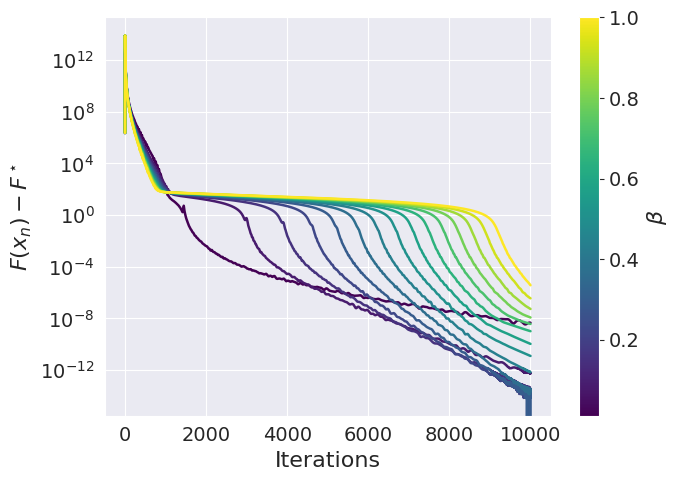

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

sns.set_style('darkgrid')
plt.rcParams.update({
    'font.size':        13,
    'figure.figsize':   (7, 5),
    'legend.fontsize':  14,
    'lines.linewidth':  2,
    'axes.labelsize':   16,
    'xtick.labelsize':  14,
    'ytick.labelsize':  14,
    'xtick.major.pad':  4,
    'ytick.major.pad':  4,
})

# betas
beta_array = np.array(beta_list)

# color mapping for beta
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=beta_array.min(), vmax=beta_array.max())

fig, ax = plt.subplots()

for beta in beta_array:
    ans_beta = results_pgrpda[beta]

    # func_value = list of F(x_n) = J(x_n, y_n, 0)
    F_vals = np.array(ans_beta[1])
    iters  = np.arange(len(F_vals))

    gap = F_vals - F_star
    # gap = np.maximum(gap, 1e-20)

    mark_every = max(1, len(iters)//11)
    color = cmap(norm(beta))

    ax.plot(
        iters,
        gap,
        color=color,
        linewidth=1.8,
        marker='',
        label='_nolegend_'
    )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\beta$')

ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel(r'$F(x_n) - F^\star$')
# ax.set_title(r'P-GRPDA: effect of $\beta$')
fig.tight_layout()
fig.savefig('PGRPDA_multi_beta_colorbar_Fgap.eps', dpi=600)
files.download('PGRPDA_multi_beta_colorbar_Fgap.eps')
plt.show()
